In [181]:
from tensorflow import keras
from keras.models import Model
from keras import Input
from keras.layers import Dense, Lambda
from tensorflow.keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import graphviz
import plotly
import plotly.express as px 
import sys
import os

main_dir=os.path.dirname(sys.path[0])

Size of X_train:  (60000, 28, 28)
Size of y_train:  (60000,)
Size of X_test:  (10000, 28, 28)
Size of y_test:  (10000,)


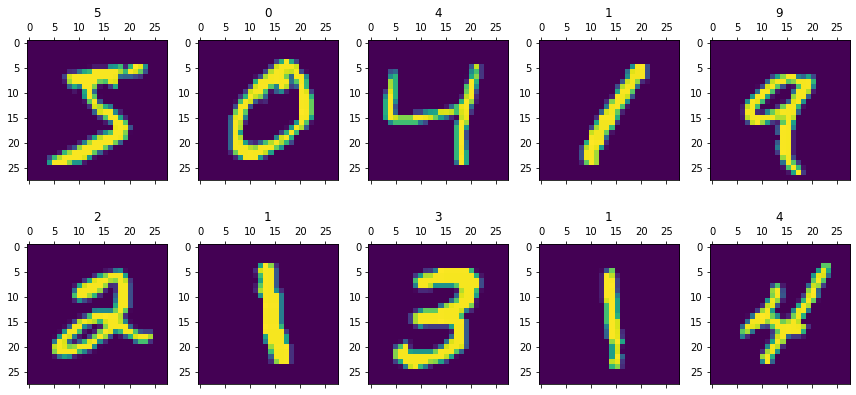

In [182]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

print("Size of X_train: ", X_train.shape)
print("Size of y_train: ", y_train.shape)
print("Size of X_test: ", X_test.shape)
print("Size of y_test: ", y_test.shape)

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

raw_data_rows = 2
raw_data_cols = 5

fig, axs = plt.subplots(raw_data_rows, raw_data_cols, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,raw_data_rows):
    for j in range(0,raw_data_cols):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title=y_train[n])
        n=n+1
plt.show() 

In [183]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

print("New size of X_train: ", X_train.shape)
print("New size of X_test: ", X_test.shape)

New size of X_train:  (60000, 784)
New size of X_test:  (10000, 784)


In [184]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

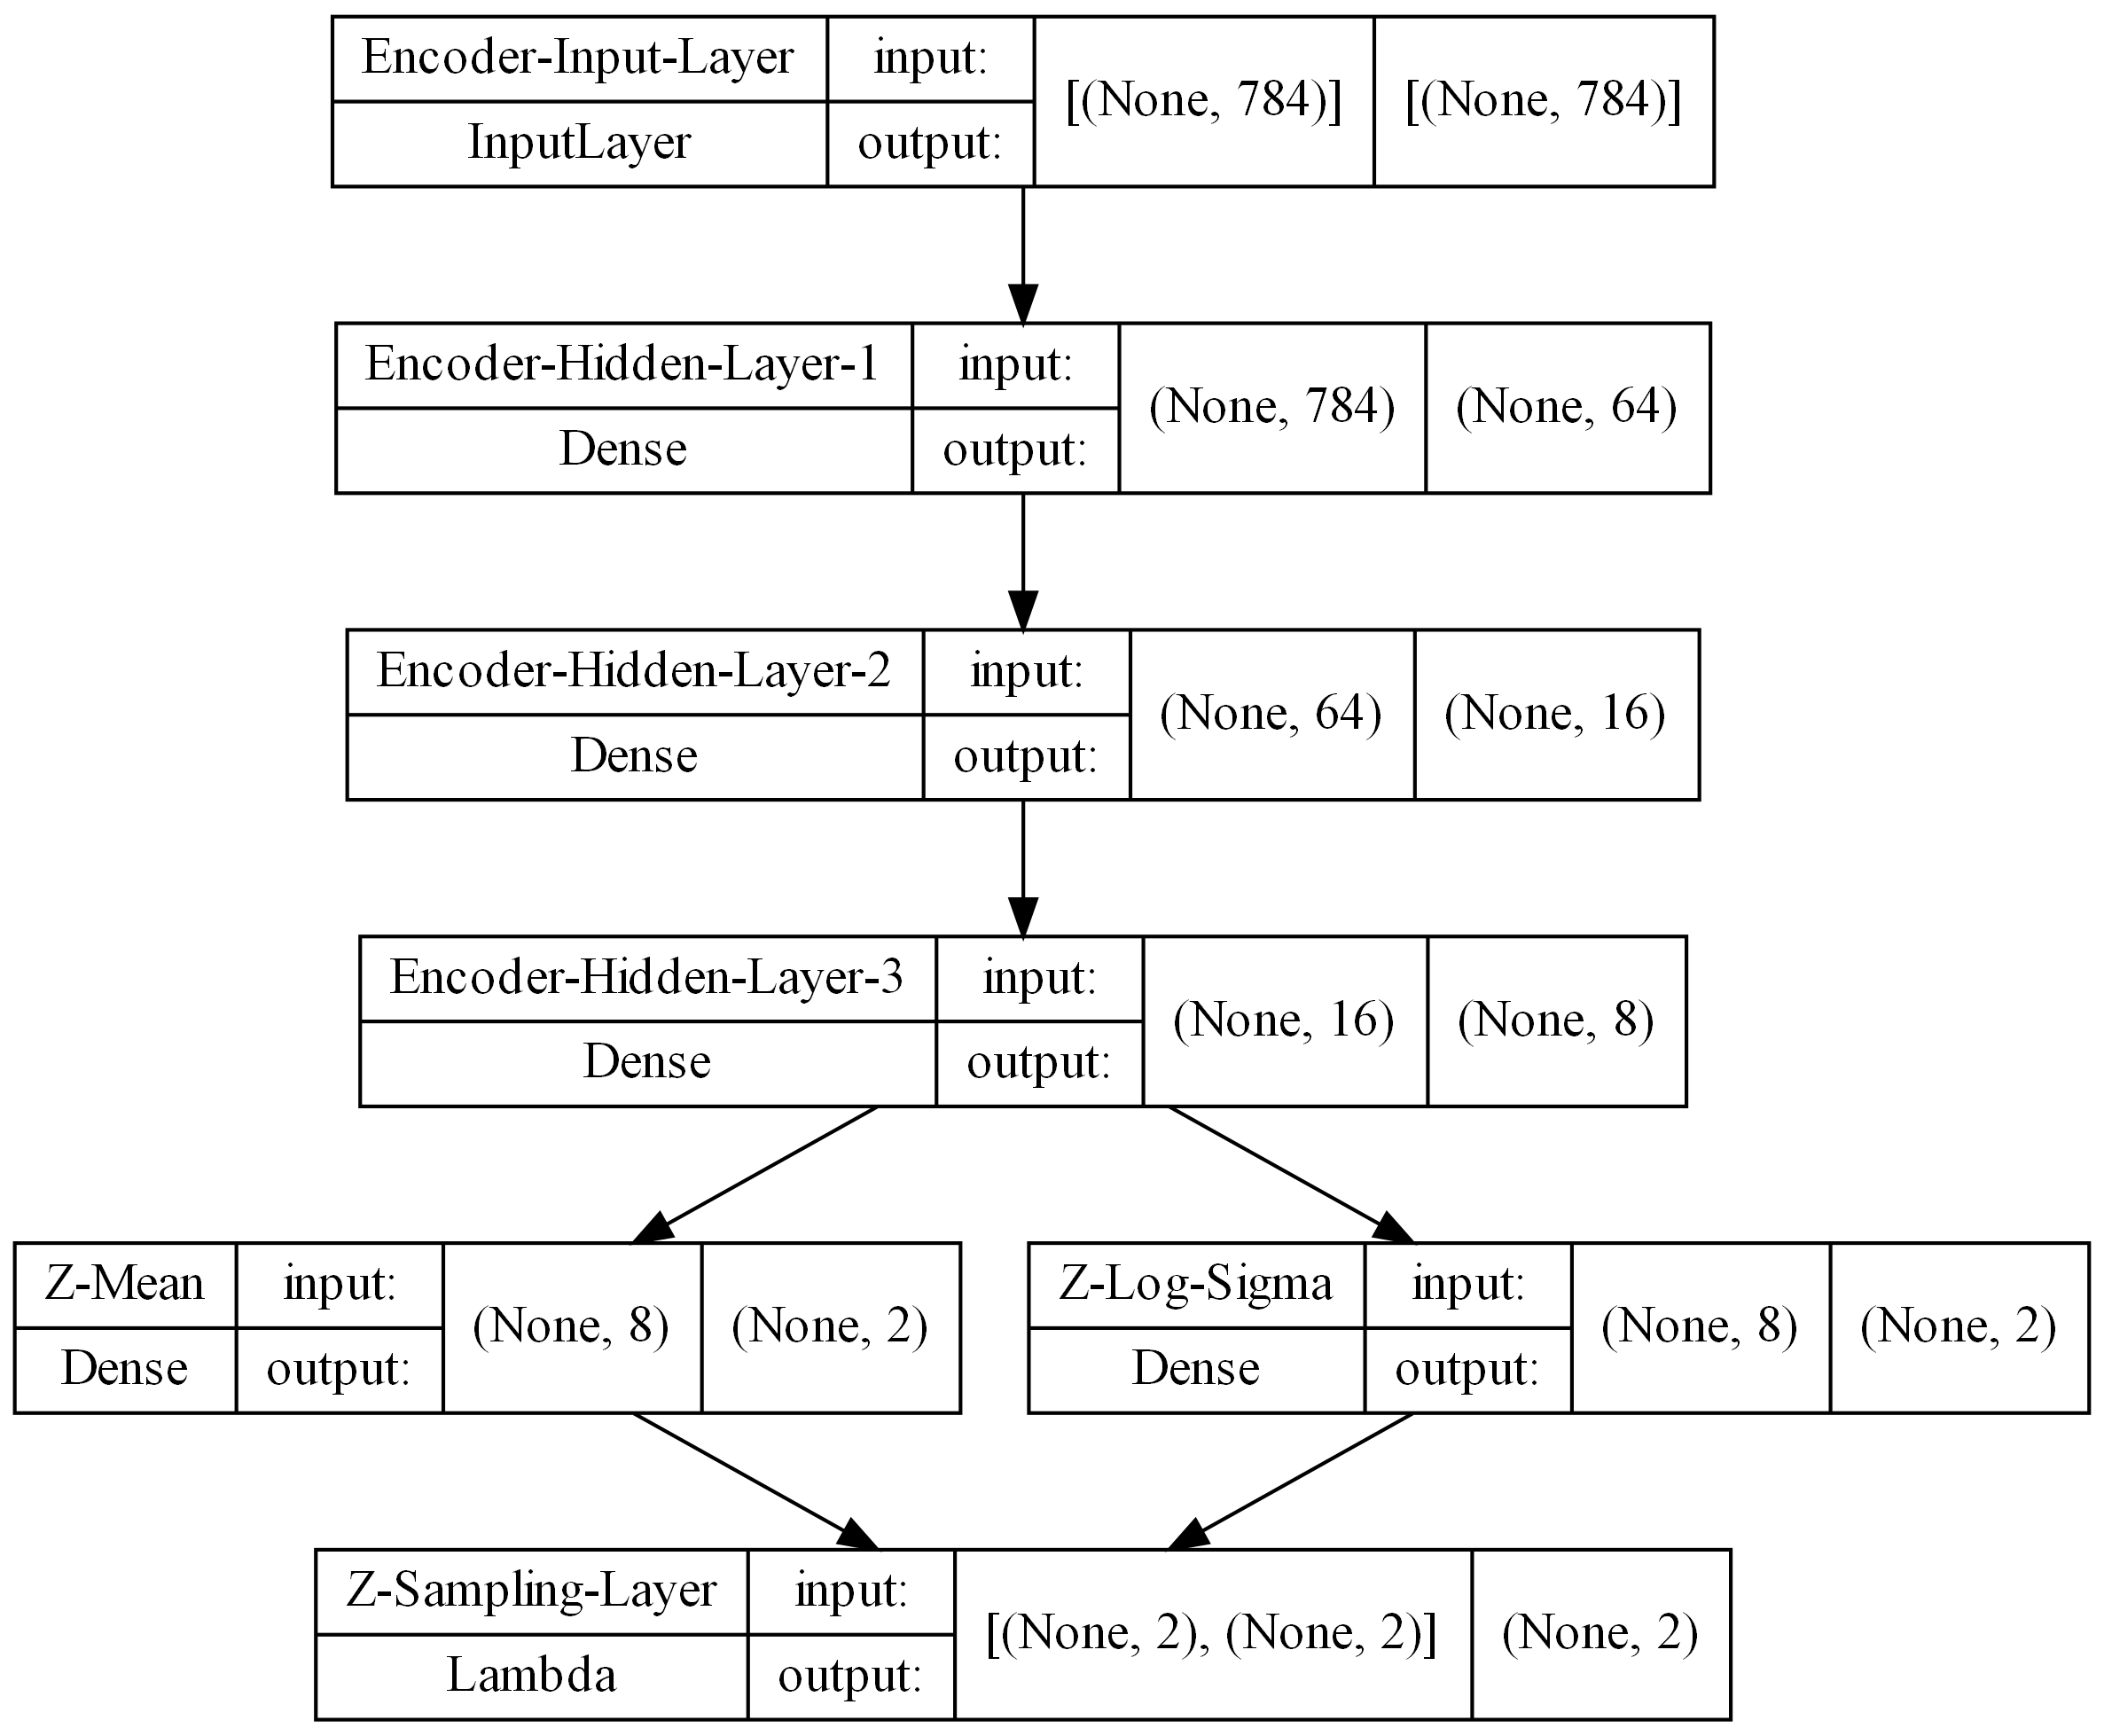

In [185]:
original_dim = 784 # (28 * 28 = 784)
latent_dim = 2 # latent space dimension

# Encoder
# Input Layer 
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

# Hidden Layer
h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

# Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

# Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

plot_model(encoder, show_shapes=True, dpi=300)

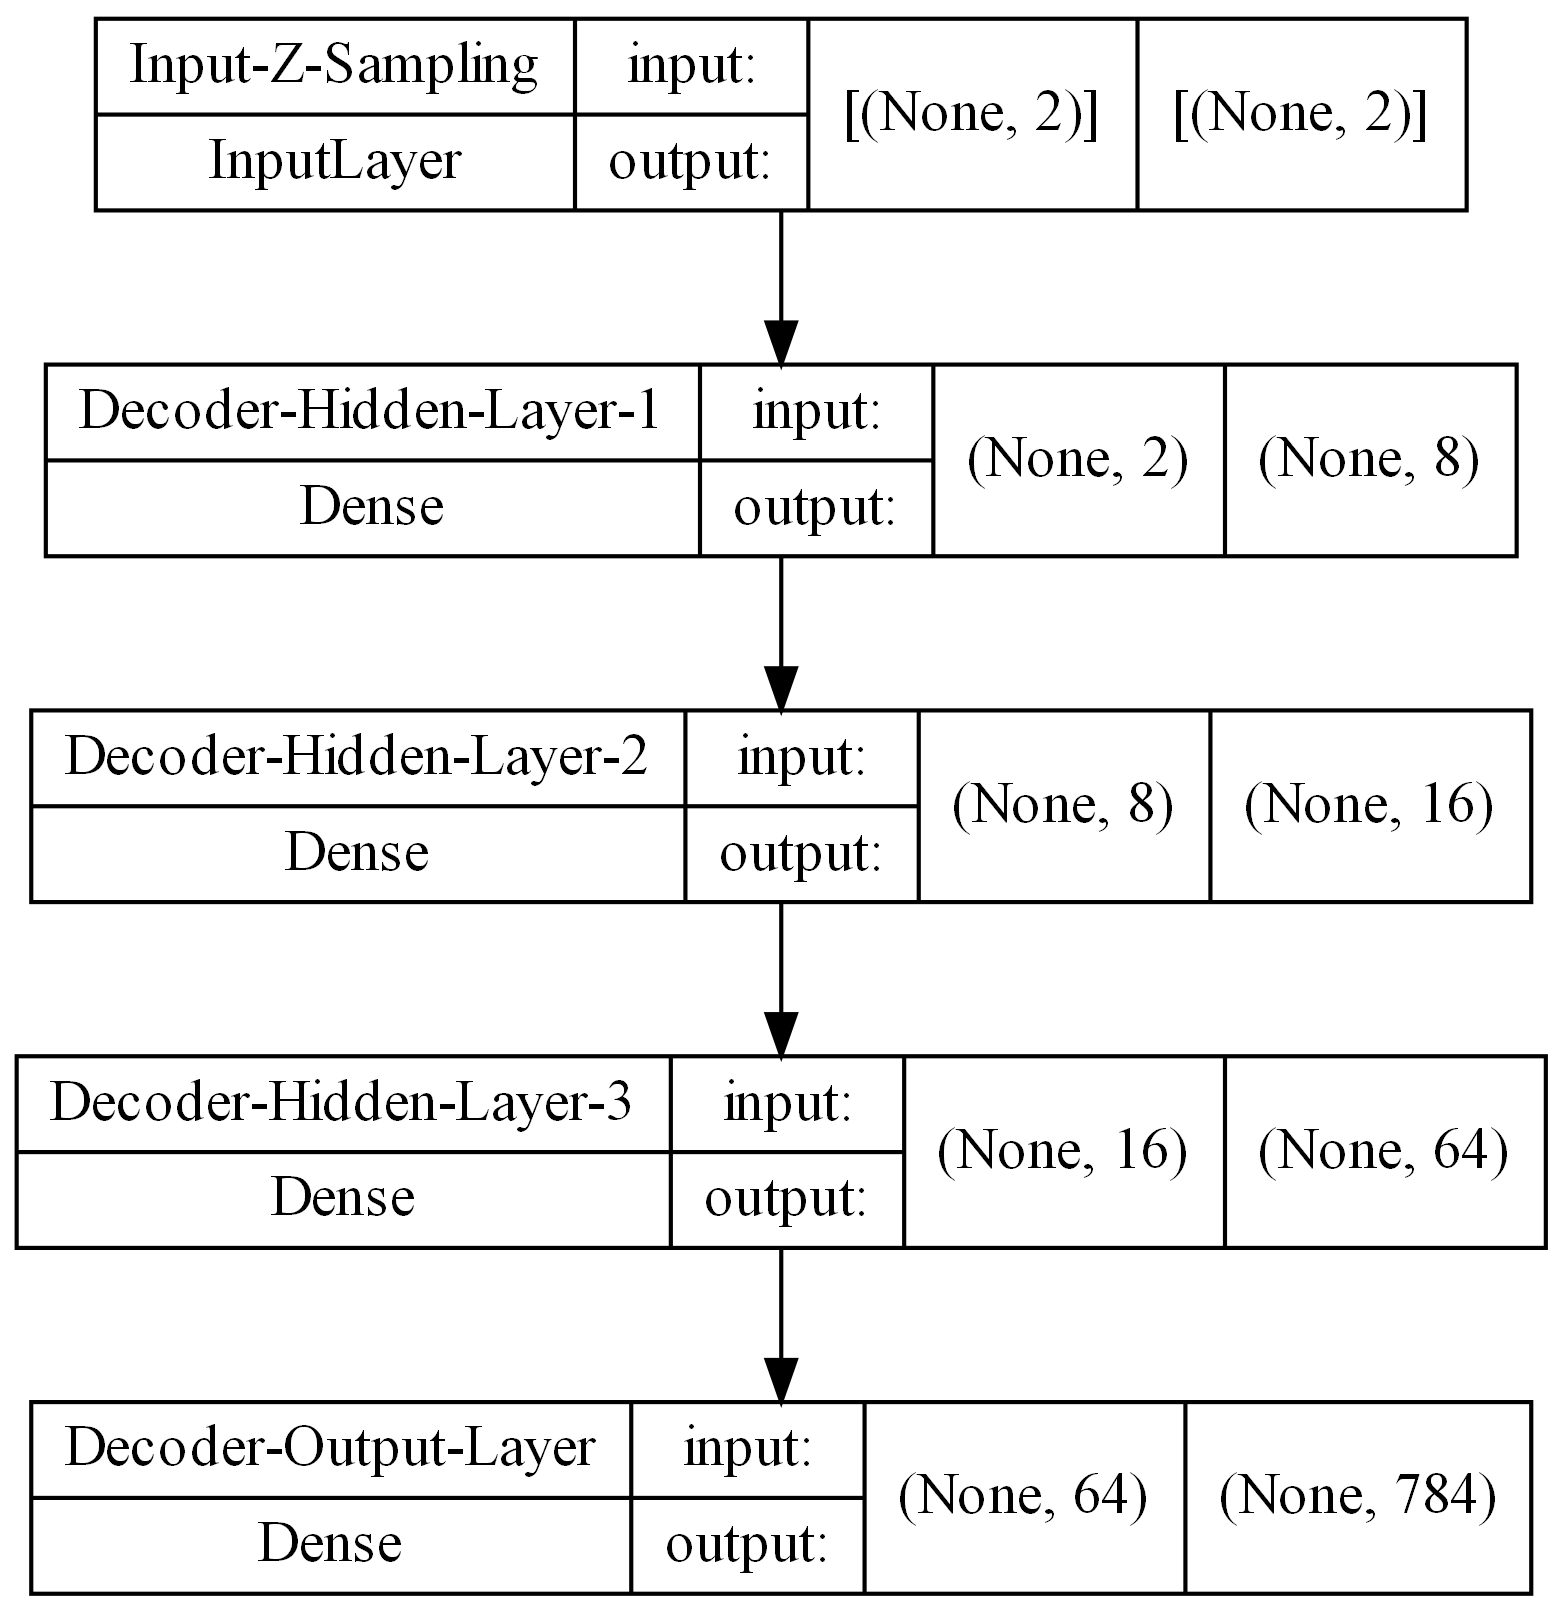

In [186]:
# Decoder

# Input Layer 
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

# Hidden Layer
h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

# Output Layer
outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

# Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

plot_model(decoder, show_shapes=True, dpi=300)

In [187]:
outpt = decoder(encoder(visible)[2]) 
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

In [188]:
# Loss
r_loss = original_dim * keras.losses.mse(visible, outpt)  # use MSE
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
vae_loss = K.mean(r_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Epoch 1/10
3750/3750 [==============================] - 5s 1ms/step - loss: 46.9649 - val_loss: 41.5775
Epoch 2/10
3750/3750 [==============================] - 5s 1ms/step - loss: 40.1631 - val_loss: 38.8566
Epoch 3/10
3750/3750 [==============================] - 6s 2ms/step - loss: 38.3161 - val_loss: 37.7952
Epoch 4/10
3750/3750 [==============================] - 6s 2ms/step - loss: 37.3117 - val_loss: 36.7771
Epoch 5/10
3750/3750 [==============================] - 6s 2ms/step - loss: 36.5911 - val_loss: 36.5157
Epoch 6/10
3750/3750 [==============================] - 6s 2ms/step - loss: 36.0716 - val_loss: 35.9203
Epoch 7/10
3750/3750 [==============================] - 6s 1ms/step - loss: 35.6310 - val_loss: 35.5072
Epoch 8/10
3750/3750 [==============================] - 6s 1ms/step - loss: 35.2513 - val_loss: 35.2906
Epoch 9/10
3750/3750 [==============================] - 6s 2ms/step - loss: 35.0615 - val_loss: 34.8924
Epoch 10/10
3750/3750 [==============================] - 6s 2ms/

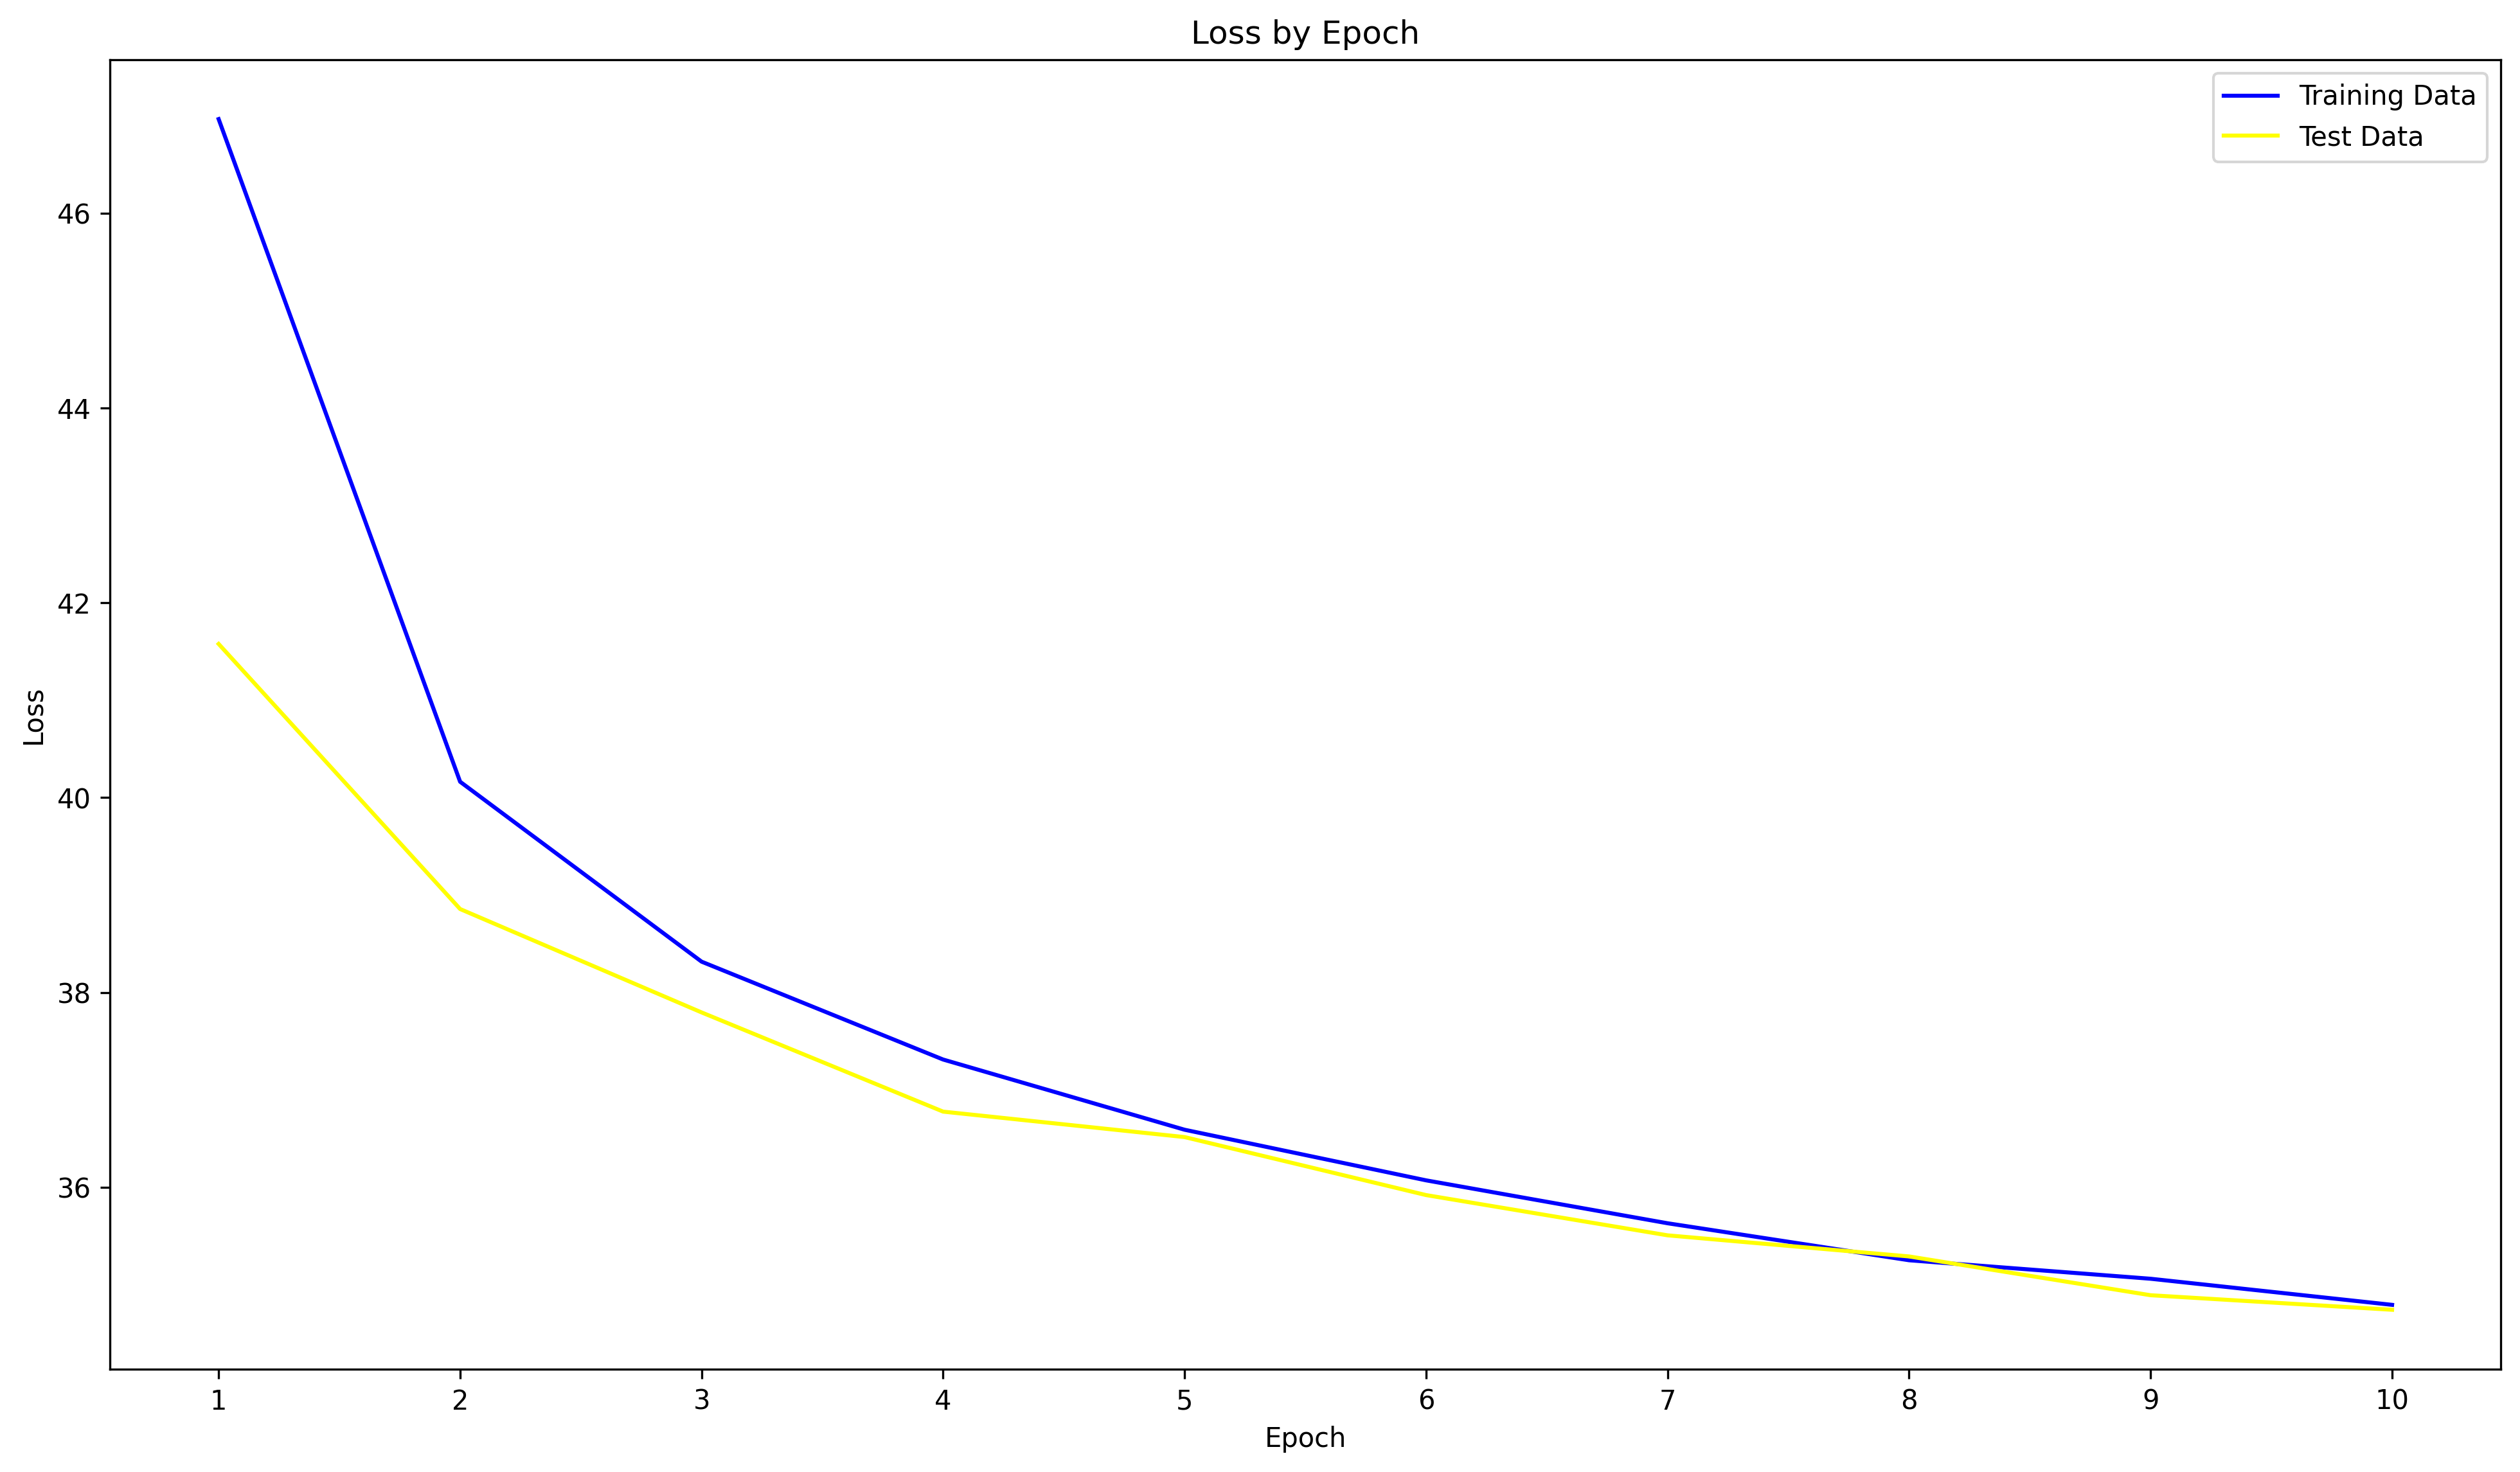

In [189]:
# history = vae.fit(X_train, X_train, epochs=50, batch_size=16, validation_data=(X_test, X_test))
history = vae.fit(X_train, X_train, epochs=10, batch_size=16, validation_data=(X_test, X_test))

fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='blue')
ax.plot(history.history['val_loss'], label='Test Data', color='yellow')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

In [190]:
X_test_encoded = encoder.predict(X_test)

fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1], 
                 opacity=1, color=y_test.astype(str))

fig.update_layout(dict(plot_bgcolor = 'white'))

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

fig.update_layout(title_text="Items representation in the 2D Latent Space")
fig.update_traces(marker=dict(size=2))
fig.show()

In [191]:
def find_closest_by_sample(sample_digit):
    coords = [list(el) for el in zip(X_test_encoded[2][:,0], X_test_encoded[2][:,1])]

    distances = np.linalg.norm(np.array(coords) - np.array(sample_digit), axis=1)
    min_index = np.argmin(distances)

    return y_test[min_index]


Current number is: 0


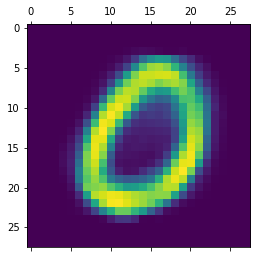

In [192]:
sample_digit=[[0,-1]]

digit_decoded = decoder.predict(sample_digit)
print(f"Current number is: {find_closest_by_sample(sample_digit)}")

plt.matshow(digit_decoded.reshape(28,28))
plt.show()

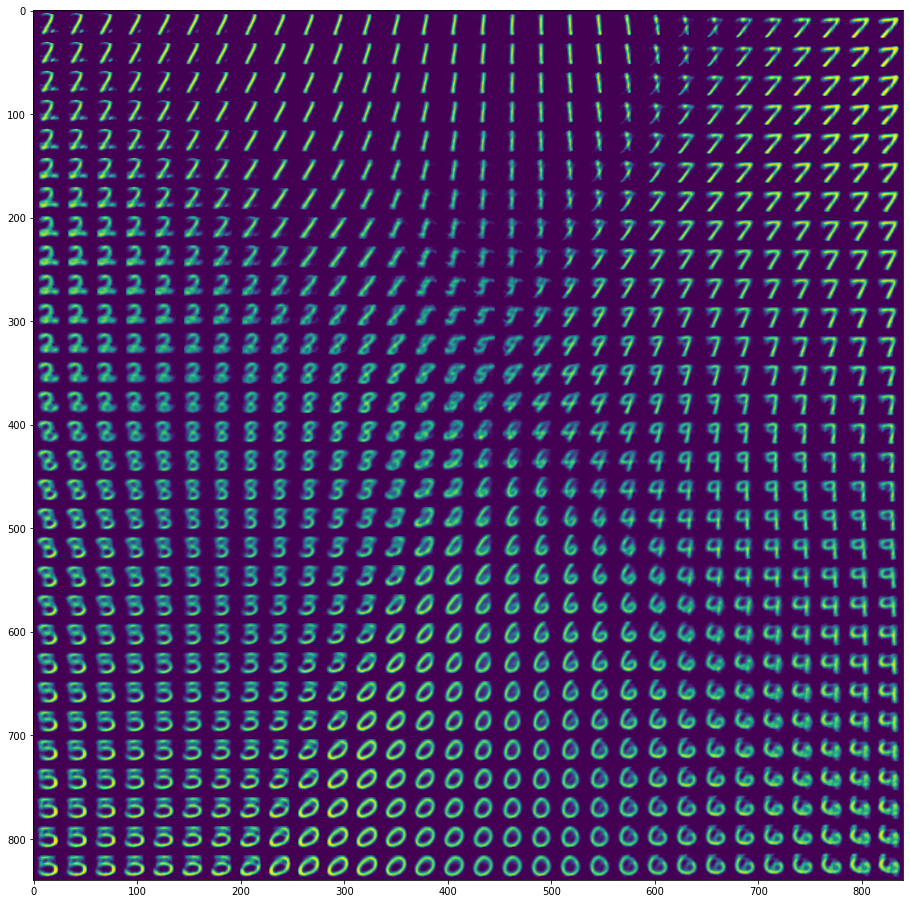

In [194]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(1.5, -1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)

output = []
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        sample = np.array([[xi, yi]])
        decoded = decoder.predict(sample)

        # output.append([decoded[0].reshape(digit_size, digit_size), find_closest_by_sample(sample)])
        output.append([decoded, find_closest_by_sample(sample)])
        
        digit = decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(18, 16))
plt.imshow(figure)
plt.show()

In [195]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train
# x_test = x_test / 255
# x_test = np.array(output[:][0])
x_train_flattened = x_train.reshape(len(x_train), 28*28)
# x_test_flattened = x_test.reshape(len(x_test), 28*28)

# Sequential create a stack of layers
model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(784,), activation='sigmoid')
])

# Optimizer will help in backproagation to reach better global optima
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Does the training
model.fit(x_train_flattened, y_train, epochs=10)
print("-"*30)
model.evaluate(np.array([el[0][0] for el in output]), np.array([el[1] for el in output]))

Epoch 1/10
1875/1875 [==============================] - 2s 823us/step - loss: 9.5042 - accuracy: 0.8410
Epoch 2/10
1875/1875 [==============================] - 1s 793us/step - loss: 6.1480 - accuracy: 0.8790
Epoch 3/10
1875/1875 [==============================] - 2s 802us/step - loss: 5.6791 - accuracy: 0.8830
Epoch 4/10
1875/1875 [==============================] - 2s 825us/step - loss: 5.5185 - accuracy: 0.8858
Epoch 5/10
1875/1875 [==============================] - 2s 866us/step - loss: 5.3797 - accuracy: 0.8858
Epoch 6/10
1875/1875 [==============================] - 2s 845us/step - loss: 5.2011 - accuracy: 0.8882
Epoch 7/10
1875/1875 [==============================] - 2s 817us/step - loss: 5.2360 - accuracy: 0.8867
Epoch 8/10
1875/1875 [==============================] - 2s 801us/step - loss: 5.2775 - accuracy: 0.8882
Epoch 9/10
1875/1875 [==============================] - 1s 783us/step - loss: 5.1397 - accuracy: 0.8908
Epoch 10/10
1875/1875 [==============================] - 1s 682u

[1.7319674491882324, 0.273333340883255]